# 数据API  The Data API

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os

def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

In [2]:
X = tf.range(10)

# 在RAM中完全创建一个数据集
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

`from_tensor_slices()`采用一个张量并创建一个`tf.data.Dataset`,其元素均为X的切片.

In [3]:
#dataset = tf.data.Dataset.range(10)

for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


## 链式转换 Chaining Transformations

按照如下结构进行链式转换:

<img src="./images/other/13-1.png" width="400">

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.repeat(1)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [5]:
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


- `repeat(n)`:返回一个新数据集,该数据集将重复原始数据n次.
- `batch(n)`:将数据集中的元素按照n个元素为一个批次分组.

In [6]:
# 若需要删除余下的批次 令drop_remainder=True 使得所有批次具有完全相同的大小
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.repeat(3).batch(7, drop_remainder=True)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)


- 通过`map()`方法变换元素,注意传递进去的参数必须可转换为`TF`函数.

In [7]:
dataset = dataset.map(lambda x: x*2)   # 原来的两倍
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


- 通过`apply()`方法变换整个数据集

In [8]:
# dataset = dataset.apply(tf.data.experimental.unbatch())  #已被弃用
dataset = dataset.unbatch()   # 分离批次

- `filter()`过滤数据集

In [9]:
dataset = dataset.filter(lambda x: x<10)

- `take()`获取部分数据集中的元素

In [10]:
for item in dataset.take(3):   
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


## 构建输入流水线 Building an Input Pipeline

### 乱序数据 Shuffling the Data

当数据集中的实例相互独立且均匀分布时,梯度下降的效果是最佳的.可以通过`shuffle()`对实例进行混洗.
- `shuffle()`:首先从源数据集中的第一项填充到缓冲区,要求提供数据时,将从缓冲区取出一个元素,并用源数据集中的一个新元素替换它,直到遍历整个源数据集和缓冲区.必须要指定缓冲区大小,使其足够大,但不要超过RAM的大小.

创建并显示一个包含0-9的数据集,重复三次,并使用大小为5的缓冲区进行乱序,并用7的批次大小进行批处理.

In [11]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)   # seed:设置随机种子 
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


对于不适合内存的大型数据集,这种简单的缓冲区乱序方法可能不够用,因为与数据集相比、缓冲区很小。

进一步乱序实例,一种常见的方法是
1. 将源数据拆分为多个文件,然后在训练过程中以随机顺序读取它们。
2. 为了避免位于同一文件中的实例仍然相互接近的情况,可以随机选择多个文件并同时读取它们,并且交错它们的记录。
3. 使用`shuffle()`添加一个乱序缓冲区。

### 拆分数据集为多个CSV文件 Split dataset to multiple CSV files

1. 以加州房价数据集为例加载数据集,并创建训练集,验证集以及测试集.

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
housing = fetch_california_housing()
X = housing.data
y = housing.target
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=42)

train_data = np.c_[X_train, y_train]
val_data = np.c_[X_val, y_val]
test_data = np.c_[X_test, y_test]

2. 拆分为多个CSV文件,保留标题行,每行包含8个输入特征和目标房屋中间值

In [14]:
def save_to_multiple_csv_file(data, name_prefix, n_parts=10, header=None):
    housing_path_save = os.path.join("datasets", "housing", "split_file")
    os.makedirs(housing_path_save, exist_ok=True)
    path_format = os.path.join(housing_path_save, "my_{}_{:02d}.csv")

    file_paths = []  # 子文件的路径列表
    m = len(data)    # len(train_data)=11610
    
    # file_index:文件索引  row_indices:行索引
    for file_index, row_indices in enumerate(np.array_split(ary=np.arange(m),
                                                            indices_or_sections=n_parts)):
        # name_prefix:文件名前缀
        path_csv = path_format.format(name_prefix, file_index)  
        # 'datasets/housing/split_file/my_train_10.csv'
        file_paths.append(path_csv)

        with open(path_csv, mode="wt", encoding="utf-8") as f:
            # 处理标题行:令每个子文件都有标题行
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_index in row_indices:
                # repr():返回对象的字符串形式
                f.write(",".join([repr(col) for col in data[row_index]]))
                f.write("\n")
    return file_paths

In [15]:
# array_split():返回一维的拆分数组,可以进行不均等的划分  
# indices_or_sections:拆分的子数组个数
test_split = enumerate(np.array_split(ary=np.arange(10), indices_or_sections=2))
for i in test_split:
    print(i)

(0, array([0, 1, 2, 3, 4]))
(1, array([5, 6, 7, 8, 9]))


In [16]:
# 标题行 
header_cols = housing.feature_names + ["MedianHouseValue"]   # 添加上标签列
header = ",".join(header_cols)
header

'MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue'

In [17]:
save_to_multiple_csv_file(data=train_data, name_prefix="train",
                          n_parts=20, header=header,)[:3]

['datasets/housing/split_file/my_train_00.csv',
 'datasets/housing/split_file/my_train_01.csv',
 'datasets/housing/split_file/my_train_02.csv']

In [18]:
train_filepaths = save_to_multiple_csv_file(train_data, "train", 20, header)
val_filepaths = save_to_multiple_csv_file(val_data, "val", 20, header)
test_filepaths = save_to_multiple_csv_file(test_data, "test", 20, header)

In [19]:
# 使用pd查看分割后的CSV文件
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [20]:
# 使用文本模式查看分割后的CSV文件
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


### 交织来自多个文件的行 Interleaving lines from multiple files

使用文件模式创建一个仅包含下面文件路径的数据集.
1.  `list_files`默认将返回乱序的文件路径的数据集.

In [21]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
for filepath in filepath_dataset.take(3):
    print(filepath)

tf.Tensor(b'datasets/housing/split_file/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/split_file/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/split_file/my_train_01.csv', shape=(), dtype=string)


2. `interleaver`实现不同文件的行交织

In [22]:
n_readers = 5
dataset = filepath_dataset.interleave(
            map_func=lambda filepath:tf.data.TextLineDataset(filepath).skip(1),
            cycle_length=n_readers,
            num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
for line in dataset.take(3):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'


- 所获取的结果为随机选择的5个CSV文件的第一行(忽略标题行)
- `TextLineDataset()`:从数据文件中读取并构造一个数据集，文本中每一行，就是一个元素.
- `interleave()`工作原理:
    1. 创建一个数据集,该数据集将从`filepath_dataset`中拉出`cycle_length`个文件路径
    2. 对于每个路径,它将调用你为其提供的函数(在此示例中为 `lambda函数` )来创建新的数据集(在此示例中为 `TextLineDataset`),得到`cycle_length`个新的数据集对象.
    3. 为了请楚起见,在此阶段总共有7个数据集:      
        - 文件路径数据集
        - 交织数据集
        - 由交织数据集在内部创建的5个`TextLineDataset`。 
    4. 然后从这些新生成的数据集对象中取数据，取数逻辑为顺序地从每个文件中一次读取一行.
 当我们遍历交织数据集时,它将循环遍历这5个`TextLineDataset`,每次读取一行直到所有数据集都读出为止.然后它将从`filepath_dataset`再次获取5个文件路径,并以相同的方式对它们进行交织,以此类推,直到读完文件路径.


- 为了交织效果更好,最好使用具有相同长度的文件。否则最长文件的结尾将不会交织。
- 默认情况下, `interleave()`不使用并行。它只是顺序地从每个文件中一次读取行。如果你希望它并行读取文件,则可以将`num_parallel_ca11s`参数设置为所需的线程数(请注意`map()`方法也具有此参数)。你甚至可以将其设置为`tf.data.AUTOTUNE`,使 Tensorflow根据可用的CPU动态地选择合适的线程数.

### 预处理数据 Preprocessing the Data

1. 预处理任务1:填充缺失值

 `decode_csv`解析一行csv文件内容,`record_defaults`字典存储各字段的默认值,缺失值将会被默认值替代.

In [24]:
sample_str = ",2,3,,5"
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv(sample_str, record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

- 缺失值将会被默认值替代
- 第5个值是强制性的(`tf.constant([])`),如果不提供会报错!
- 字段数应与记录中的字段数完全匹配

2. 预处理任务2:特征缩放

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_   # 均值
X_std = scaler.scale_   # 标准差

3. 预处理函数

In [26]:
@tf.function   # 使用AutoGraph机制 加快训练深度
def preprocess(line):
    # 默认所有特征列为浮点数0，同时提供float32的空数组作为标签并且是强制性的
    defaults = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defaults)
    # tf.stack():将这些张量堆叠到一维度量中
    X = tf.stack(fields[:-1])
    y = tf.stack(fields[-1])
    return (X - X_mean) / X_std ,y

In [27]:
n_inputs = 8
preprocess(b'3.9688,41.0,5.259786476868327,0.9715302491103203,916.0,3.2597864768683276,33.98,-118.07,1.698')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.04035116,  0.9789995 , -0.07691002, -0.27522123, -0.46386182,
         0.12743382, -0.78068835,  0.75683004], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.698>)

### 合并在一起 Putting Everything Together

将上述内容放在一个辅助函数里面:创建并返回一个数据集,该数据集从多个CSV文件中加载加州住房数据,对其进行预处理,随机乱序,可以选择重复,并进行批处理.

<img src="./images/other/13-2.png" width="400">

In [28]:
def csv_reader_dataset(filepaths, repeat=1, n_reader=5, n_read_threads=tf.data.AUTOTUNE, 
                       shuffle_buffer_size=10000, batch_size=32):
    filepath_dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = filepath_dataset.interleave(
        map_func=lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_reader,
        num_parallel_calls=n_read_threads,  # 设置并行处理的线程数
    )
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(map_func=preprocess, num_parallel_calls=n_read_threads)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)  # 提升性能
    return dataset

### 预取 Prefetching

`prefetch()`:使得数据集将尽最大可能提前准备一个批次.

通过预取,CPU和GPU并行工作:当GPU处理一个批次时,CPU处理下个批次.

<img src="./images/other/13-3.png" width="400">

如果数据集足够小,可以放到内存里,则可以使用数据集的`cache()`将其内容放到RAM中,从而加快训练速度.

###  和tf.keras一起使用数据集 Using the Dataset with tf.keras

1. 将拆分后的CSV文件通过输入流水线创建数据集

In [29]:
train_dataset = csv_reader_dataset(filepaths=train_filepaths,
                                  # repeat=None
                                  )
# repeat=None 使用跨轮次的乱序缓冲区
val_dataset = csv_reader_dataset(filepaths=val_filepaths)
test_dataset = csv_reader_dataset(filepaths=test_filepaths)

2. 构建模型编译及训练

In [30]:
initialization()

In [31]:
input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation=keras.activations.relu,
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [32]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

batch_size=32
model.fit(train_dataset,
          #steps_per_epoch=len(X_train) // batch_size,
          epochs=10,
          validation_data=val_dataset
         )

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.6474 - val_loss: 0.8067
Epoch 2/10
363/363 [==============================] - 0s 822us/step - loss: 0.7083 - val_loss: 0.6589
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6347 - val_loss: 0.6020
Epoch 4/10
363/363 [==============================] - 0s 909us/step - loss: 0.5979 - val_loss: 0.5659
Epoch 5/10
363/363 [==============================] - 0s 832us/step - loss: 0.5703 - val_loss: 0.5362
Epoch 6/10
363/363 [==============================] - 0s 868us/step - loss: 0.5477 - val_loss: 0.5138
Epoch 7/10
363/363 [==============================] - 0s 876us/step - loss: 0.5286 - val_loss: 0.5060
Epoch 8/10
363/363 [==============================] - 0s 849us/step - loss: 0.5131 - val_loss: 0.4828
Epoch 9/10
363/363 [==============================] - 0s 876us/step - loss: 0.4994 - val_loss: 0.4686
Epoch 10/10
363/363 [==============================] - 0s 870us/step - loss: 0.4873 - 

3. 测试与预测

In [33]:
model.evaluate(test_dataset)

162/162 [==============================] - 0s 611us/step - loss: 0.4765


0.4764833450317383

In [34]:
new_set = test_dataset.map(lambda X, y: X) 
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[1.3617018],
       [5.936318 ],
       [1.1038496],
       ...,
       [0.6972577],
       [1.7134535],
       [2.3925939]], dtype=float32)

# TFRecord格式 The TFRecord Format

`TFRecord格式`是TensorFlow首选的格式,用于存储大量数据并有效读取数据。这是一种非常简单的二进制格式,只包含大小不同的二进制记录序列(每个记录由一个长度,一个用于检查长度是否损坏的CRC校验和,实际数据以及最后一个CRC校验和组成)

- 创建TFRecord文件

In [35]:
with tf.io.TFRecordWriter("./TFRecord/my_data.tfrecord") as f:
    f.write(b"Hello world!___This is first record")
    f.write(b"Hello world!___This is second record")

- 读取TFRecord文件

In [36]:
filepath = ["./TFRecord/my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepath, num_parallel_reads=tf.data.AUTOTUNE)
for item in dataset:
    print(item)

tf.Tensor(b'Hello world!___This is first record', shape=(), dtype=string)
tf.Tensor(b'Hello world!___This is second record', shape=(), dtype=string)


默认情况下, 将一个接一个地读取文件,可以设置`num_parallel_reads`使其并行读取多个文件并交织记录。

## 压缩的TFRecord文件 Compressed TFRecord Files

- 通过设置`options`创建压缩文件

In [37]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("./TFRecord/my_compressed.tfrecord", options=options) as f:
    f.write(b"Hello world!___This is first record")
    f.write(b"Hello world!___This is second record")

- 解压文件时要主要指定压缩类型

In [38]:
filepath = ["./TFRecord/my_compressed.tfrecord"]
dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP",
                                  num_parallel_reads=tf.data.AUTOTUNE)
for item in dataset:
    print(item)

tf.Tensor(b'Hello world!___This is first record', shape=(), dtype=string)
tf.Tensor(b'Hello world!___This is second record', shape=(), dtype=string)


> 后续内容 等待补充!

In [39]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

# 预处理输入特征 Preprocessing the Input Features

1. 下载并解压CSV数据集

In [40]:
import tarfile
import urllib.request

In [41]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

2. 加载数据集

In [42]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [43]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 特征列 feature columns

深度神经网络只能处理数值类型的数据，但我们收集的特征并不全是数值类型的。

机器学习模型一般将分类值表示为简单的矢量，其中 1 表示存在某个值，0 表示不存在某个值。例如，如果将`product_class`设置为`sports`时，机器学习模型通常将`product_class`表示为[0, 0, 1]，即：

- 0：kitchenware is absent。
- 0：electronics is absent。
- 1：sports is present。


因此，虽然原始数据可以是数值或分类值，但机器学习模型会将所有特征表示为数值。

如下图所示，你可以通过 `Estimator` 的 `feature_columns` 参数来指定模型的输入。特征列在输入数据（由`input_fn`返回）与模型之间架起了桥梁。

<img src="./images/other/13-4.jpg" width="700">

要创建特征列，请调用 `tf.feature_column` 模块的函数。本文档介绍了该模块中的 9 个函数。如下图所示，除了 `bucketized_column` 外的函数要么返回一个 `Categorical Column` 对象，要么返回一个 `Dense Column` 对象。
<img src="./images/other/13-5.jpg" width="500">

如下所示，并非所有 `Estimator` 都支持所有类型的 `feature_columns` 参数：

- `LinearClassifier` 和 `LinearRegressor`：接受所有类型的特征列。
- `DNNClassifier` 和 `DNNRegressor`：只接受密集列。其他类型的列必须封装在 `indicator_column` 或 `embedding_column` 中。
- `DNNLinearCombinedClassifier` 和 `DNNLinearCombinedRegressor`：`linear_feature_columns `参数接受任何类型的特征列,`dnn_feature_columns` 参数只接受密集列。


创建Demo数据集:

In [44]:
demo_data = {'marks': [55,21,63,88,74,54,95,41,84,52],
        'grade': ['average','poor','average','good','good','average','good','average','good','average'],
        'point': ['c','f','c+','b+','b','c','a','d+','b+','c']}
 
demo_df = pd.DataFrame(demo_data)
demo_df

,marks,grade,point
0,55,average,c
1,21,poor,f
2,63,average,c+
3,88,good,b+
4,74,good,b
5,54,average,c
6,95,good,a
7,41,average,d+
8,84,good,b+
9,52,average,c


In [45]:
from tensorflow import feature_column

In [46]:
# 用于创建特征列和转换批量数据
def Conver_fn(feature_column, data):
    # DenseFeatures:用来将原始数据根据需要转换为特征数据
    feature_layer = keras.layers.DenseFeatures(feature_column)
    print(feature_layer(data)[:5])

### 数值列 Numeric column

1. Demo数据集

In [47]:
marks = feature_column.numeric_column("marks")
Conver_fn(feature_column=marks, data=demo_data)

tf.Tensor(
[[55.]
 [21.]
 [63.]
 [88.]
 [74.]], shape=(5, 1), dtype=float32)


2. 加州住房数据集:`housing_median_age`

- `DataFrame.to_dict()` 函数转化为字典类型:
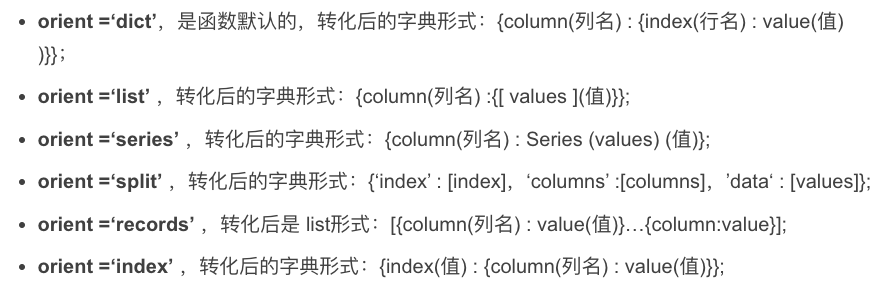

In [48]:
# 1. 首先进行数据类型转换
housing_dict = housing.to_dict(orient="list")
housing_dict.keys()

dict_keys(['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity'])

In [49]:
# 2. 指定特征列
housing_median_age = feature_column.numeric_column("housing_median_age")
housing_median_age  # normalizer_fn=None 未指定归一化函数

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [50]:
# 3. 转换为特征数据
Conver_fn(data=housing_dict, feature_column=housing_median_age)

tf.Tensor(
[[41.]
 [21.]
 [52.]
 [52.]
 [52.]], shape=(5, 1), dtype=float32)


In [51]:
# 4. 指定normalizer_fn 
age_mean = X_mean[1]     # 由sklearn所加载的加州房价数据集 房龄类是在[1]上
age_stds = X_std[1]
housing_median_age = feature_column.numeric_column(
                        key="housing_median_age",
                        normalizer_fn=lambda x:(x-age_mean)/age_stds)
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x7fbf7d7244d0>)

In [52]:
Conver_fn(data=housing_dict, feature_column=housing_median_age)

tf.Tensor(
[[ 0.9789995 ]
 [-0.60316414]
 [ 1.8491895 ]
 [ 1.8491895 ]
 [ 1.8491895 ]], shape=(5, 1), dtype=float32)


### 分桶列 Bucketized column

通常，我们不直接将一个数值直接传给模型，而是根据数值范围将其值分为不同的 `categories`。上述功能可以通过 `tf.feature_column.bucketized_column`实现。以表示房屋建造年份的原始数据为例。我们并非以标量数值列表示年份，而是将年份分成下列四个分桶：
<img src="./images/other/13-6.png" width="500">
模型将按以下方式表示这些 bucket：
<img src="./images/other/13-7.png" width="200">

为什么要将数字（一个完全有效的模型输入）拆分为分类值？

首先，该分类将单个输入数字分成了一个四元素矢量。因此模型现在可以学习四个单独的权重而不是一个。四个权重能够创建一个更强大的模型。更重要的是，借助 bucket，模型能够清楚地区分不同年份类别，因为仅设置了一个元素 (1)，其他三个元素则被清除 (0)。例如，当我们仅将单个数字（年份）用作输入时，线性模型只能学习线性关系，而使用 bucket 后，模型可以学习更复杂的关系。请注意，指定一个三元素边界矢量可创建一个四元素 bucket 矢量.

- 分列桶演示

1. Demo数据集

In [53]:
Conver_fn(feature_column=marks, data=demo_data)

tf.Tensor(
[[55.]
 [21.]
 [63.]
 [88.]
 [74.]], shape=(5, 1), dtype=float32)


In [54]:
# 1. 首先转换成数值列
marks = feature_column.numeric_column("marks")
# 2. 按照边界进行 bucket
marks_buckets = feature_column.bucketized_column(
                    source_column=marks, 
                    boundaries=[30,40,50,60,70,80,90])
Conver_fn(feature_column=marks_buckets, data=demo_data)

tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]], shape=(5, 8), dtype=float32)


2. 加州住房数据集:`median_income`

In [55]:
median_income = feature_column.numeric_column("median_income")
Conver_fn(feature_column=median_income, data=housing_dict)

tf.Tensor(
[[8.3252]
 [8.3014]
 [7.2574]
 [5.6431]
 [3.8462]], shape=(5, 1), dtype=float32)


In [56]:
median_income = feature_column.numeric_column("median_income")
median_income_buckets = feature_column.bucketized_column(
                            source_column=median_income,
                            boundaries=[1.5, 3., 4.5, 6.])
Conver_fn(feature_column=median_income_buckets, data=housing_dict)

tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]], shape=(5, 5), dtype=float32)


In [57]:
# 指定normalizer_fu进行归一化之后在进行bucket
# 以housing_median_age为例:
Conver_fn(data=housing_dict, feature_column=housing_median_age)

tf.Tensor(
[[ 0.9789995 ]
 [-0.60316414]
 [ 1.8491895 ]
 [ 1.8491895 ]
 [ 1.8491895 ]], shape=(5, 1), dtype=float32)


In [58]:
housing_median_age_bucket = feature_column.bucketized_column(
                                source_column=housing_median_age,
                                boundaries=[-1., -0.5, 0., 0.5, 1])
Conver_fn(data=housing_dict, feature_column=housing_median_age_bucket)

tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]], shape=(5, 6), dtype=float32)


### 分类列 Categorical Column

#### 类别标识列 Categorical identity column

可以将`类别标识列`看成`分桶列`的一个特例。在一般的`分桶列`中，每一个 `分桶`表示值的一个范围。在一个`类别标识列`中，每个 `分桶` 表示单个、独一无二的整数。例如，假设您想要表示整数范围 [0, 4)。也就是说，您想要表示整数 0、1、2 或 3。在这种情况下，分类标识映射如下所示:
<img src="./images/other/13-8.png" width="300">

- `categorical_column_with_identity` 创建类别标识列

####  类别词汇表 Categorical vocabulary column

我们不能直接向模型中输入字符串。我们必须首先将字符串映射为数值或类别值。`类别词汇表` 可以将字符串表示为one_hot格式的向量。

- `categorical_column_with_vocabulary_list`:由列表加载
- `categorical_column_with_vocabulary_file`:由文件加载

<img src="./images/other/13-9.jpg" width="300">

### 指示列和嵌入列 Indicator and embedding columns

`指标列`和`嵌入列`从不直接处理特征，而是将**`分类列`**视为输入。
- `indicator_column` 把输入编码为`多热编码multi-hot`或者`独热编码one-hot的 dense形式`
- `categorical` 把输入编码为`独热编码的sparse形式`

所以如果要把`categorical` 特征送入 DNN 网络，必须使用`指示列`或`嵌入列`进行一次转换.

#### 指示列 Indicator columns

`indicator_column`是一个onehot工具，用于把sparse特征进行onehot 变换.

使用指标列时，我们指示 `TensorFlow` 完成我们在分类 `product_class` 样本中看到的确切操作。也就是说，指标列将每个类别视为独热矢量中的一个元素，其中匹配类别的值为 1，其余类别为 0.
<img src="./images/other/13-8.png" width="300">

- 指示列演示

1. Demo数据集

In [59]:
# 1.创建 分类列-类别词汇表
grade = feature_column.categorical_column_with_vocabulary_list(
            key='grade',
            vocabulary_list=['poor','average','good'],
)

In [60]:
# 2.将分类列指定为指示列 
grade_indictor = feature_column.indicator_column(grade)

In [61]:
grade_indictor

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='grade', vocabulary_list=('poor', 'average', 'good'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

In [62]:
# 3.转换为特征数据
Conver_fn(feature_column=grade_indictor, data=demo_data)

tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]], shape=(5, 3), dtype=float32)


2. 加州住房数据集:`ocean_proximity`

In [63]:
housing.ocean_proximity.head()

0    NEAR BAY
1    NEAR BAY
2    NEAR BAY
3    NEAR BAY
4    NEAR BAY
Name: ocean_proximity, dtype: object

In [64]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
ocean_proximity = feature_column.categorical_column_with_vocabulary_list(
                    key='ocean_proximity',
                    vocabulary_list=vocab)

ocean_indictor = feature_column.indicator_column(ocean_proximity)
Conver_fn(feature_column=ocean_indictor, data=housing_dict)

tf.Tensor(
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]], shape=(5, 5), dtype=float32)


#### 嵌入列 Embedding columns

假设我们有一百万个可能的类别，或者可能有十亿个，而不是只有三个。出于多种原因，随着类别数量的增加，使用指标列来训练神经网络变得不可行。

我们可以使用嵌入列来克服这一限制。嵌入列并非将数据表示为很多维度的独热矢量，而是将数据表示为**低维度普通矢量，其中每个单元格可以包含任意数字**，而不仅仅是 0 或 1。通过使每个单元格能够包含更丰富的数字，嵌入列包含的单元格数量远远少于指标列。

我们来看一个将指标列和嵌入列进行比较的示例。假设我们的输入样本包含多个不同的字词（取自仅有 81 个字词的有限词汇表）。我们进一步假设数据集在 4 个不同的样本中提供了下列输入字词：

- “dog”
- “spoon”
- “scissors”
- “guitar”

<img src="./images/other/13-10.jpg" width="500">

处理样本时，其中一个 `categorical_column_with... `函数会将样本字符串映射到分类数值。然后通过作为`指示列`或`嵌入列`来表示这些分类数值.

嵌入矢量中的值如何神奇地得到分配？实际上，分配值在训练期间进行。也就是说，**模型学习了将输入分类数值映射到嵌入矢量值以解决问题的最佳方法**。嵌入列可以增强模型的功能，因为嵌入矢量从训练数据中学习了类别之间的新关系。

`dimension嵌入矢量维数`应该是类别数量的 4 次方根。


由于本示例中的词汇量为 7，建议维数为 $7^{0.25}≈2$：

- 嵌入列演示

1. Demo数据集

In [65]:
# 1.创建分类列
point_data = demo_df['point'].unique()
# array(['c', 'f', 'c+', 'b+', 'b', 'a', 'd+'])
point = feature_column.categorical_column_with_vocabulary_list(
            key='point',
            vocabulary_list=point_data)

In [66]:
# 将分类列转换为指示列
point_indicator = feature_column.indicator_column(point)
# 转换为特征数据
Conver_fn(feature_column=point_indicator, data=demo_data)

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]], shape=(5, 7), dtype=float32)


In [67]:
# 2.将分类列指定为嵌入列
point_embedding = feature_column.embedding_column(
                    categorical_column=point,
                    dimension=2)   # dimension 嵌入向量的维度

# 3.转换为特征数据
Conver_fn(feature_column=point_embedding, data=demo_data)

tf.Tensor(
[[-0.39534152 -0.3781051 ]
 [-1.1119912   0.56957847]
 [-0.00292093  0.12198265]
 [ 0.20670882  0.31640428]
 [-0.14504611  0.7563394 ]], shape=(5, 2), dtype=float32)


### 哈希列 Hashed column

当类别的数量特别大时，我们不可能为每个词汇或整数设置单独的类别，因为这将会消耗非常大的内存。

`categorical_column_with_hash_bucket`使您能够指定类别的数量:无需提供词汇表,模型会计算输入值的 hash 值，然后使用**模运算** 将其置于其中一个 `hash_bucket_size` 类别中

In [68]:
demo_df

,marks,grade,point
0,55,average,c
1,21,poor,f
2,63,average,c+
3,88,good,b+
4,74,good,b
5,54,average,c
6,95,good,a
7,41,average,d+
8,84,good,b+
9,52,average,c


In [69]:
# 创建分类列
point_hash = feature_column.categorical_column_with_hash_bucket(
                key='point',
                hash_bucket_size=4)

In [70]:
# 将分类列指定为指示列
point_indicator = feature_column.indicator_column(point_hash)
# 转换为特征数据
Conver_fn(feature_column=point_indicator, data=demo_data)

tf.Tensor(
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]], shape=(5, 4), dtype=float32)


存在的问题:不同字符串可能映射到同一个存储桶的冲突.事实证明哈希技术经常非常有用。这是因为哈希类别为模型提供了一些分隔方式。模型可以使用其他特征进一步将厨具与运动用品分隔开来。

<img src="./images/other/13-13.jpg" width="500">

### 组合列 Crossed column

通过将多个特征组合为一个特征，模型可学习每个特征组合的单独权重。

假设我们希望模型计算佐治亚州亚特兰大的房地产价格:这个城市的房地产价格在不同位置差异很大.在确定对房地产位置的依赖性方面，将纬度和经度表示为单独的特征用处不大；但是，将纬度和经度组合为一个特征则可精确定位位置。

假设我们将亚特兰大表示为一个 100x100 的矩形网格区块，按纬度和经度的特征组合标识全部 10000 个区块。借助这种特征组合，模型可以针对与各个区块相关的房价条件进行训练，这比单独的经纬度信号强得多。

<img src="./images/other/13-14.jpg" width="500">

In [71]:
data = {'marks': [55,21,63,88,74,54,95,41,84,52],
        'grade': ['average','poor','average','good','good','average','good','average','good','average'],
        'point': ['c','f','c+',' b+','b','c','a','d+','b+','c']}
        
# 将数值列进行分桶
marks = feature_column.numeric_column("marks")  
marks_buckets = feature_column.bucketized_column(
                    source_column=marks, 
                    boundaries=[30,40,50,60,70,80,90])
 
# 创建 类别词汇表
grade = feature_column.categorical_column_with_vocabulary_list(
    'grade', ['poor', 'average', 'good']
)

# 创建组合列
crossed_feature = feature_column.crossed_column(
                    keys=[marks_buckets, grade], 
                    hash_bucket_size=10)

为了避免创建一个完整的巨大输入表，`crossed_column` 通过`hash_bucket_size` 参数来控制组合后的特征的维度。特征列通过对输入元组进行 hash 及 模运算 来为输入指定一个索引。

如前面所说，进行“hash”和“模运算”可以限制`categories`的数量，但是可能导致`category`冲突：多个组合特征可能会位于相同的 `hash bucket`中。不过，在实践中特征组合仍能够有效地提升模型的效果。

在创建特征组合时，通常**仍应在模型中包含原始（未组合）特征**。独立的纬度和经度特征有助于模型区分组合特征中发生哈希冲突的样本。

In [72]:
# 将分类列指定为指示列
crossed_indicator = feature_column.indicator_column(crossed_feature)
# 转换为特征数据
Conver_fn(feature_column=crossed_indicator, data=demo_data)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)


## 使用独热向量编码分类特征 Encoding Categorical Features Using One-Hot Vectors

使用在第2章中使用的加州住房数据集，因为它包含分类特征`ocean_proximity`和缺少的值.

In [73]:
pd.unique(housing['ocean_proximity'])

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

由于类别很少可以使用独热编码,为此需要将每个类别映射到其索引(0~4).这可以使用查找表完成:

1. 首先**定义词汇表**,这是所有可能类别的列表.然后创建相应索引的张量.

In [74]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
indices

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 2, 3, 4])>

2. 接下来为查找表**创建一个初始化程序**,将类别列表及其索引传递给它.

In [75]:
table_init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=indices)

3. **创建查找表**,并为其提供初始化程序并指定了词汇表外`out-of-vocabulary (oov)`桶的数量.如果我们査找词汇表中不存在的类别，则査找表将计算该类别的哈希并将这个未知类別分配给`oov`桶之中的一个。它们的素引从已知类别开始，因此在此示例中，两个`oov`桶的索引为5和6.

In [76]:
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(initializer=table_init,
                                        num_oov_buckets=num_oov_buckets)
table

为什么要使用`oov`桶？如果类别数量很大(例如邮政编码、城市、单词，产品或用户) 且数据集也很大，或者将它们一直在变化，那么得到类别的完整列表可能不是很方便.

一种解决方法是基于数据样本(而不是整个训练集)定义词汇表，并为不在数据样本的其他类别添加一些桶。你希望在训练期间找到的类别越多，就应该使用越多的`oov`桶。如果没有足够的`oov`桶，就会发生冲突：不同的类别最终会出现在同一个桶中，因神经网络将无法区分它们(至少不是基于这个特征)

4. 使用查找表将一小批分类特征编码为**独热编码**.

In [77]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND", "DESERT"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 5, 1, 1, 5])>

其中未知类别`DESERT`被映射到两个`oov`桶之一 (在索引5),而`INLAND`被映射到索引1两次.

 `tf.one_hot()` 对这些素引进行独热编码。注意我们必须告诉该函数索引的总数，该总数等于**词汇表大小加上oov桶的数量**.

In [78]:
cat_one_hot = tf.one_hot(indices=cat_indices,
                         depth=len(vocab)+num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

这可能不是最佳解决方法。每个独热向量的大小是词汇表长度加上`oov`桶数。当只有几个可能的类別时这很可行,但是**如果词汇表很大,则使用`嵌入embedding`対它们进行编码会更有效**。

- 如果类别数少于10,则通常采用独热编码方式.
- 如果类别数大于50(通常这种情况需要使用哈希桶),通常最好使用嵌入.
- 在10到50个类别中,你可能需要尝试两种方法,然后看看哪种最适合你.

## 使用嵌入编码类型特征 Encoding Categorical Features Using Embeddings

`嵌入Embeddings`是一个可训练的表示类型的紧密矢量.默认,嵌入是随机初始化的.当嵌入表示相似的类时,梯度下降会使相似的嵌入靠的更近,反之则偏的越远.事实上,表征越好,越利于神经网络做出准确的预测.

<img src="./images/other/13-11.png" width="400">

### 手动实现嵌入 implement embeddings manually

1. 首先创建一个每个嵌入类别的嵌入矩阵,并随机初始化.

<img src="./images/other/13-12.png" width="500">

In [79]:
initialization()

In [80]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
num_oov_buckets = 2
embeedings_dim = 2  # 嵌入维度

row = len(vocab) + num_oov_buckets   # 5+2=7
column = embeedings_dim
input_shape = (row, column)     # 7*2

embeddings_init = tf.random.uniform(shape=input_shape)
embeddings_matric = tf.Variable(embeddings_init)      # tf.Variable声明训练参数
embeddings_matric

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.6645621 , 0.44100678],
       [0.3528825 , 0.46448255],
       [0.03366041, 0.68467236],
       [0.74011743, 0.8724445 ],
       [0.22632635, 0.22319686],
       [0.3103881 , 0.7223358 ],
       [0.13318717, 0.5480639 ]], dtype=float32)>

2. 使用查找表将一小批分类特征编码为**嵌入**.

In [81]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND", "DESERT"])
cat_indices = table.lookup(keys=categories)
cat_indices

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 5, 1, 1, 5])>

In [82]:
# 根据给定的索引在嵌入矩阵中查找行
tf.nn.embedding_lookup(params=embeddings_matric, ids=cat_indices)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.74011743, 0.8724445 ],
       [0.3103881 , 0.7223358 ],
       [0.3528825 , 0.46448255],
       [0.3528825 , 0.46448255],
       [0.3103881 , 0.7223358 ]], dtype=float32)>

### 使用Keras提供的层

In [83]:
row = len(vocab) + num_oov_buckets
embedding = keras.layers.Embedding(input_dim=row,
                                   output_dim=embeedings_dim)
embedding(cat_indices)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.04467482,  0.02493341],
       [-0.02383961,  0.01973433],
       [ 0.04309944, -0.0247813 ],
       [ 0.04309944, -0.0247813 ],
       [-0.02383961,  0.01973433]], dtype=float32)>

接下来我们将这些内容放在一起,创建一个`kreas`模型,用于处理类型特征和数值特征,并且学习每个类型的嵌入(包括词汇表外类型).

In [84]:
initialization()

In [85]:
# 1. 模型输入
regular_inputs = keras.layers.Input(shape=[8])  # 8个数值特征
categories = keras.layers.Input(shape=[], dtype=tf.string)  # 1个类别特征

In [86]:
# 2. 处理类别特征 使用Lambda查找索引再查找嵌入
cat_indices = keras.layers.Lambda(lambda cats:table.lookup(cats))(categories)
cat_embedding = keras.layers.Embedding(input_dim=row,
                                       output_dim=embeedings_dim)(cat_indices)

In [87]:
# 3. 将数值特征和处理后的类别特征连接
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embedding])

In [88]:
# 4. 模型输出
output = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories],
                           outputs=[output])

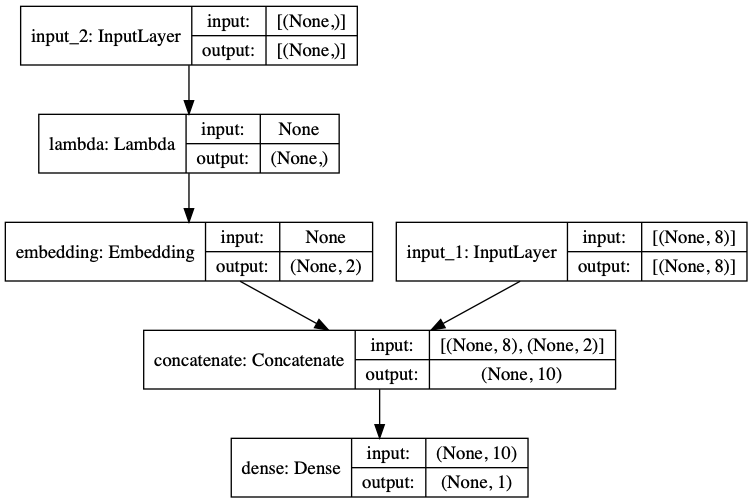

In [89]:
keras.utils.plot_model(model, "./models/plot_model/embedding_model.png", show_shapes=True)

使用独热编码再加`Dense层`等价于`嵌入层`,但`嵌入层`计算更少,`Dense层`的权重矩阵扮演的的是嵌入矩阵的角色.

## Keras 预处理层 Keras Preprocessing Layers

对于`Feature Columns API`:
- `Normalization`用来做特征标准化
- `TextVectorization`层用于将 文本中的词 编码为 词典的索引.
    - 当`TextVectorization`准备好之后，可以调用它的`adapt()`方法，从数据样本提取词表（会自动创建查找表）。然后加入到模型中，就可以执行索引查找了（替换前面代码的`Lambda`层）。
    - 可以用于输出词频向量，而不是词索引。
        - 例如，如果词典包括三个词，比如["and", "basketball", "more"]，则"more and more"会映射为[1, 0, 2]："and"出现了一次，"basketball"没有出现，"more"出现了两次。这种词表征称为`词袋bag of words`，因为它完全失去了词的顺序。
        
        - 常见词，比如"and"，会在文本中有更高的值，尽管没什么实际意义。因此应该用减少常用单词重要性的方式对单词计数进行归一化.
        
        - 一个常见的方法是将 词频除以出现该词的文档数的对数。这种方法称为`词频-逆文档频率TF-IDF`。
            - 例如，假设"and"、"basketball"、"more"分别出现在了200、10、100个文档中：最终的矢量应该是[$\frac{1}{log(200)}$, $\frac{0}{log(100)}$, $\frac{2}{log(100)}$]，大约是[0.19, 0., 0.43]。
- `layers.Discretization`层，它能将连续数据切成不同的离散块，将每个块编码为独热矢量。
    - 例如，可以用它将价格分成是三类，低、中、高，编码为[1, 0, 0]、[0, 1, 0]、[0, 0, 1].
    - `Discretization`层是不可微的，只能在模型一开始使用。事实上，模型的预处理层会在训练时冻结，因此预处理层的参数不会被梯度下降影响.这还意味着，如果想让预处理层可训练的话，不能在自定义预处理层上直接使用嵌入层，而是应该像前面的例子那样将其单独添加到你的模型中.
- `PreprocessingStage`类将多个预处理层链接起来.


In [90]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


1. `housing_median_age`指定为`数值列` 并且指定`normalizer_fn `.进一步指定为`分桶列`

In [91]:
age_mean = X_mean[1]   
age_stds = X_std[1]
housing_median_age = feature_column.numeric_column(
                        key="housing_median_age",
                        normalizer_fn=lambda x:(x-age_mean)/age_stds)
bucketized_age = feature_column.bucketized_column(
                source_column=housing_median_age,
                boundaries=[-1., -0.5, 0., 0.5, 1.])

2. `median_income`指定为`分桶列`

In [92]:
median_income = feature_column.numeric_column("median_income")
median_income_buckets = feature_column.bucketized_column(
                            source_column=median_income,
                            boundaries=[1.5, 3., 4.5, 6.])

3. `ocean_proximity`指定为`分类列-类别词汇表`

In [93]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
ocean_proximity = feature_column.categorical_column_with_vocabulary_list(
                    key='ocean_proximity',
                    vocabulary_list=vocab)

4. `city`指定为`哈希列` (仅为示例)

In [94]:
city = feature_column.categorical_column_with_hash_bucket(
            key="city",
            hash_bucket_size=1000)

5. `bucketized_age` 和`ocean_proximity`指定为`组合列`

In [95]:
age_and_ocean_crossed = feature_column.crossed_column(
                            keys=[bucketized_age, ocean_proximity],
                            hash_bucket_size=100)

6. `longitude`和`latitude`指定为`组合列`

In [96]:
latitude = feature_column.numeric_column('latitude')
longitude = feature_column.numeric_column('longitude')

latitude_bucket = feature_column.bucketized_column(
                    source_column=latitude,
                    boundaries=list(np.linspace(32., 42., 20-1)))
longitude_bucket = feature_column.bucketized_column(
                    source_column=longitude,
                    boundaries=list(np.linspace(-125., -114., 20 - 1)))

location = feature_column.crossed_column(
                keys=[latitude_bucket, longitude_bucket],
                hash_bucket_size=1000)

7. `ocean_proximity`进一步指定为`指示列`/`嵌入列`

In [97]:
ocean_indictor = feature_column.indicator_column(ocean_proximity)

ocean_embedding = feature_column.embedding_column(
                    categorical_column=ocean_indictor,
                    dimension=2)   

### 使用特征列进行解析 Using Feature Columns for Parsing

> 后续内容 等待补充!

## TF Transform

预处理非常消耗算力，训练前做预处理相对于实时处理，可以极大的提高速度：数据在训练前，每个实例就处理一次，而不是在训练中每个实例在每个周期就处理一次。

前面提到过，如果数据集小到可以存入内存，可以使用`cache()`方法。但如果太大，可以使用`Apache Beam`或`Spark`。它们可以在大数据上做高效的数据预处理，还可以分布进行，使用它们就能在训练前处理所有训练数据了。

存在的问题：一旦模型训练好了，假如想部署到移动app上，还是需要写一些预处理数据的代码。

解决办法:
- 在部署到app或浏览器之前，给训练好的模型加上额外的预处理层，来做实时的预处理.
- 如果只需定义一次预处理操作呢？这就是`TF Transform`要做的。`TF Transform`是`TensorFlow Extended (TFX)`的一部分，这是一个端到端的TensorFlow模型生产化平台。通过`TF Transform`函数来做缩放、分桶等操作，一次性定义预处理函数。

`TF Transform`可以使用任意需要的`TensorFlow`运算。如果只有两个特征，预处理函数可能如下：

In [98]:
# import tensorflow_transform as tft

# def preprocess(inputs):  # inputs = 输入特征批次
#     median_age = inputs["housing_median_age"]
#     ocean_proximity = inputs["ocean_proximity"]
#     standardized_age = tft.scale_to_z_score(median_age)
#     ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
#     return {
#         "standardized_median_age": standardized_age,
#         "ocean_proximity_id": ocean_proximity_id
#     }

然后，`TF Transform`可以使用`Apache Beam`在整个训练集上应用这个`preprocess()`。

在使用过程中，还会计算整个训练集上的必要统计数据,计算这些数据的组件称为`分析器analyzers`。

更重要的，`TF Transform`还会生成一个等价的`TensorFlow`函数，可以放入部署的模型中。这个TF函数包括一些常量，对应于Apache Beam的统计值（平均值、标准差和词典）。

有了`Data API`、`TFRecord`，`Keras预处理层`和`TF Transform`，可以搭建高度可扩展的输入流水线来进行训练，并且在生产环境中的快速而编写的数据预处理中收益。

# TensorFlow 数据集项目The TensorFlow Datasets (TFDS) Project

从`TensorFlow Datasets`项目，可以非常方便的下载一些常见的数据集，从小数据集，比如`MNIST`或`Fashion MNIST`，到大数据集，比如ImageNet（需要大硬盘）。包括了图片数据集、文本数据集（包括翻译数据集）、和音频视频数据集。

In [99]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [101]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [102]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 749us/step - loss: 31.8386 - accuracy: 0.8414
Epoch 2/5
1875/1875 [==============================] - 1s 499us/step - loss: 25.8769 - accuracy: 0.8686
Epoch 3/5
1875/1875 [==============================] - 1s 522us/step - loss: 24.9838 - accuracy: 0.8728
Epoch 4/5
1875/1875 [==============================] - 1s 499us/step - loss: 24.4950 - accuracy: 0.8767
Epoch 5/5
1875/1875 [==============================] - 1s 506us/step - loss: 23.8529 - accuracy: 0.8778


# TensorFlow Hub

`TensorFlow Hub` 是用于存储可重用机器学习资产的开放仓库和库.`hub.tensorflow.google.cn` 仓库中提供了许多预训练模型：文本嵌入向量、图像分类模型、TF.js/TFLite 模型等。该仓库向社区贡献者开放。

借助 `tensorflow_hub` 库，您可以下载并以最少的代码量在 `TensorFlow `程序中重用这些模型。

In [103]:
initialization()

In [104]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [105]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [106]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       

> Apotosome 12/13/21